In [23]:
# !pip install cudf

In [24]:
import torch
print("PyTorch CUDA available:", torch.cuda.is_available())

# import cudf
# print("cuDF version:", cudf.__version__)


PyTorch CUDA available: True


In [25]:
!pip install paddlepaddle-gpu

In [26]:
# Install libraries in the Jupyter Lab environment
!pip install paddleocr pymupdf numpy pillow


In [29]:
import csv
import re
from paddleocr import PaddleOCR
import fitz  # PyMuPDF
import numpy as np
from PIL import Image


# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Define the path and page range (use relative path if necessary)
pdf_path = "Primer.pdf"  # Modify if your file location is different
PAGE_NUM = 500  # Adjust for actual page range

# Define file paths for CSV and text output within the Docker workspace
csv_path = "extracted_exercises-4.csv"
text_path = "extracted_content-4.txt"

# Run the main OCR extraction and write results to files
with open(csv_path, mode='w', newline='', encoding='utf-8') as csv_file, \
     open(text_path, mode='a', encoding='utf-8') as text_file:  # Open text file in append mode

    writer = csv.writer(csv_file)
    writer.writerow(["Exercise Number", "Question Text"])

    # Regular expression to detect exercise questions (e.g., "Exercise 2.1")
    exercise_pattern = re.compile(r"^(Exercise\s+\d+\.\d+):?\s*(.*)")

    # Process each page for OCR
    with fitz.open(pdf_path) as pdf:
        for pg_num in range(230, PAGE_NUM):
            page = pdf[pg_num]

            # Increase DPI for rendering to improve OCR accuracy (e.g., 300 DPI)
            mat = fitz.Matrix(1.5, 1.5)  # 1.5x scaling for higher resolution
            pm = page.get_pixmap(matrix=mat, alpha=False)

            # Convert the pixmap to a numpy array
            img = np.array(Image.frombytes("RGB", [pm.width, pm.height], pm.samples))

            # OCR on the image
            result = ocr.ocr(img, cls=True)
            print(f"OCR result for page {pg_num + 1}:", result)  # Debug output

            # Append page header to the text file
            text_file.write(f"Page {pg_num + 1}:\n")

            # Initialize variables for accumulating multi-line questions
            current_exercise = None
            current_question = []

            # Process OCR output
            for line in result:
                for entry in line:
                    text = entry[1][0].strip()  # Extract recognized text and strip whitespace
                    text_file.write(text + "\n")  # Append entire OCR text to the text file

                    # Check if text matches the exercise pattern
                    match = exercise_pattern.match(text)
                    if match:
                        # If we already have a question accumulated, save it
                        if current_exercise and current_question:
                            writer.writerow([current_exercise, ' '.join(current_question)])

                        # Start a new exercise question
                        current_exercise = match.group(1)  # Extract "Exercise 2.1"
                        current_question = [match.group(2)]  # Start new question text

                    elif current_exercise:
                        # Accumulate lines that are likely part of the same question
                        current_question.append(text)

            # After looping, write any remaining question
            if current_exercise and current_question:
                writer.writerow([current_exercise, ' '.join(current_question)])

            text_file.write("\n")  # Add newline between pages in the text file

print("Exercises dataset created successfully at:", csv_path)
print("Full text content saved successfully at:", text_path)


[2025/04/23 21:44:51] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\raksh/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\raksh/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', 

RuntimeError: (PreconditionNotMet) The third-party dynamic library (cudnn64_8.dll) that Paddle depends on is not configured correctly. (error code is 126)
  Suggestions:
  1. Check if the third-party dynamic library (e.g. CUDA, CUDNN) is installed correctly and its version is matched with paddlepaddle you installed.
  2. Configure third-party dynamic library environment variables as follows:
  - Linux: set LD_LIBRARY_PATH by `export LD_LIBRARY_PATH=...`
  - Windows: set PATH by `set PATH=XXX; (at ..\paddle\phi\backends\dynload\dynamic_loader.cc:312)


In [31]:
from paddleocr import PaddleOCR
import re
import csv

# Paths
pdf_path = 'PrimerIndex.pdf'  # Replace with your PDF file path
output_csv_path = 'index-exercise.csv'

# Step 1: Use OCR to extract text from the PDF
def extract_index_from_pdf(pdf_path):
    ocr = PaddleOCR(lang='en')
    results = ocr.ocr(pdf_path, rec=True)
    
    # Combine text from all lines
    extracted_text = "\n".join([line[1][0] for page in results for line in page])
    return extracted_text

# Step 2: Format the index text
def format_index_text(raw_text):
    # Adjusted pattern to match the structure in raw_text
    index_pattern = re.compile(r"(?P<number>\d+(\.\d+)*)(?:\s+)(?P<name>.*?)(?:\s+\.{3,}\s+\d+)?$")
    formatted_text = []
    
    for line in raw_text.splitlines():
        match = index_pattern.match(line.strip())
        if match:
            formatted_text.append(line.strip())
    return "\n".join(formatted_text)

# Step 3: Parse formatted text into structured data
def parse_index_to_csv_format(index_text):
    data = []
    index_pattern = re.compile(r"(?P<number>\d+(\.\d+)*)(?:\s+)(?P<name>.*?)(?:\s+\.{3,}\s+\d+)?$")
    
    for line in index_text.splitlines():
        match = index_pattern.match(line.strip())
        if match:
            exercise_number = match.group("number").strip()  # Extract exercise number
            chapter_name = match.group("name").strip()       # Extract chapter name
            data.append((exercise_number, chapter_name))
    return data

# Step 4: Save the data to a CSV file
def save_to_csv(data, output_csv_path):
    with open(output_csv_path, mode='w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Exercise Number", "Chapter Name"])
        writer.writerows(data)

# Main Execution
raw_text = extract_index_from_pdf(pdf_path)
formatted_index_text = format_index_text(raw_text)
# print(formatted_index_text)
data = parse_index_to_csv_format(formatted_index_text)
print(data)
save_to_csv(data, output_csv_path)

print(f"Index text extracted and saved to: {output_csv_path}")


[2025/04/23 21:46:47] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\raksh/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\raksh/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', 

FileNotFoundError: no such file: 'PrimerIndex.pdf'

In [ ]:
import pandas as pd

# Load the CSV file
file_path = "/workspace/PYQAnalyser/extracted_exercises.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Define a mapping of exercise ranges to chapter names
chapter_mapping = {
    "Getting started": [f"Exercise 1.{i}" for i in range(1, 100)],
    "Variable and Basic types": [f"Exercise 2.{i}" for i in range(1, 100)],
    "Strings, Vectors, and Arrays": [f"Exercise 3.{i}" for i in range(1, 139)],
    "Expressions": [f"Exercise 4.{i}" for i in range(1, 391)],
    "Statements": [f"Exercise 5.{i}" for i in range(1, 319)],
    "Functions": [f"Exercise 6.{i}" for i in range(1, 319)],
    "Classes": [f"Exercise 7.{i}" for i in range(1, 391)],
    "The IO Library": [f"Exercise 8.{i}" for i in range(1, 391)],
    "Sequential Containers": [f"Exercise 9.{i}" for i in range(1, 392)],
    "Generic Algorithms": [f"Exercise 10.{i}" for i in range(1, 319)],
    "Associative Containers": [f"Exercise 11.{i}" for i in range(1, 139)],
    "Dynamic Memory": [f"Exercise 12.{i}" for i in range(1, 139)],
    "Copy Control": [f"Exercise 13.{i}" for i in range(1, 139)],
    "Operator Overloading": [f"Exercise 14.{i}" for i in range(1, 139)],
    "Object-Oriented Programming": [f"Exercise 15.{i}" for i in range(1, 139)],
    "Templates": [f"Exercise 16.{i}" for i in range(1, 319)],
    "Specialised Library Facilities": [f"Exercise 17.{i}" for i in range(1, 139)],
    "Tools for Large Programs": [f"Exercise 18.{i}" for i in range(1, 139)],
    "Specialised Tools and Techniques": [f"Exercise 19.{i}" for i in range(1, 139)],
    # Add more chapters here if needed
}

# Initialize the new column with default values
df["Chapter name"] = "Unknown"

# Map chapter names to the appropriate exercises
for chapter, exercises in chapter_mapping.items():
    df.loc[df["Exercise Number"].isin(exercises), "Chapter name"] = chapter

# Save the updated CSV
output_file = "/workspace/PYQAnalyser/questions-1.csv"  # Replace with your desired output path
df.to_csv(output_file, index=False)

print(f"Updated CSV saved to {output_file}")


Updated CSV saved to /workspace/PYQAnalyser/questions-1.csv


In [ ]:
import pandas as pd

# Load the CSV file
file_path = "/workspace/PYQAnalyser/extracted_exercises-3.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Define a mapping of exercise ranges to chapter names
chapter_mapping = {
    "Getting started": [f"Exercise 1.{i}" for i in range(1, 100)],
    "Variable and Basic types": [f"Exercise 2.{i}" for i in range(1, 100)],
    "Strings, Vectors, and Arrays": [f"Exercise 3.{i}" for i in range(1, 139)],
    "Expressions": [f"Exercise 4.{i}" for i in range(1, 391)],
    "Statements": [f"Exercise 5.{i}" for i in range(1, 319)],
    "Functions": [f"Exercise 6.{i}" for i in range(1, 319)],
    "Classes": [f"Exercise 7.{i}" for i in range(1, 391)],
    "The IO Library": [f"Exercise 8.{i}" for i in range(1, 391)],
    "Sequential Containers": [f"Exercise 9.{i}" for i in range(1, 392)],
    "Generic Algorithms": [f"Exercise 10.{i}" for i in range(1, 319)],
    "Associative Containers": [f"Exercise 11.{i}" for i in range(1, 139)],
    "Dynamic Memory": [f"Exercise 12.{i}" for i in range(1, 139)],
    "Copy Control": [f"Exercise 13.{i}" for i in range(1, 139)],
    "Operator Overloading": [f"Exercise 14.{i}" for i in range(1, 139)],
    "Object-Oriented Programming": [f"Exercise 15.{i}" for i in range(1, 139)],
    "Templates": [f"Exercise 16.{i}" for i in range(1, 319)],
    "Specialised Library Facilities": [f"Exercise 17.{i}" for i in range(1, 139)],
    "Tools for Large Programs": [f"Exercise 18.{i}" for i in range(1, 139)],
    "Specialised Tools and Techniques": [f"Exercise 19.{i}" for i in range(1, 139)],
    # Add more chapters here if needed
}

# Initialize the new column with default values
df["Chapter name"] = "Unknown"

# Map chapter names to the appropriate exercises
for chapter, exercises in chapter_mapping.items():
    df.loc[df["Exercise Number"].isin(exercises), "Chapter name"] = chapter

# Save the updated CSV
output_file = "/workspace/PYQAnalyser/questions-3.csv"  # Replace with your desired output path
df.to_csv(output_file, index=False)

print(f"Updated CSV saved to {output_file}")


Updated CSV saved to /workspace/PYQAnalyser/questions-3.csv


In [ ]:
csv_files = ["/workspace/PYQAnalyser/questions-1.csv", "/workspace/PYQAnalyser/questions-2.csv", "/workspace/PYQAnalyser/questions-3.csv"]
combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index = True)
output_file = "/workspace/PYQAnalyser/questionsPrimer.csv"
combined_df.to_csv(output_file, index=False)

In [ ]:
import csv
import re
from paddleocr import PaddleOCR
import fitz  # PyMuPDF
import numpy as np
from PIL import Image

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Define file paths
pdf_path = r"PYQAnalyser/programmingPrinciples.pdf"
csv_path = r"PYQAnalyser/extracted_questions-bjarne-2.csv"

# Regular expressions
section_pattern = re.compile(r'^(Review|Exercises)\s*$', re.IGNORECASE)
question_pattern = re.compile(r'^(\d+\.?)\s*(.*)')  # Matches '1.' or '1 '

# Initialize CSV
with open(csv_path, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Page Number", "Question Text"])

    # Process PDF with PaddleOCR
    with fitz.open(pdf_path) as pdf:
        for pg_num in range(400, 805):  # Adjust page range as needed
            page = pdf[pg_num]
            mat = fitz.Matrix(2.0, 2.0)  # Enhance resolution for OCR
            pm = page.get_pixmap(matrix=mat, alpha=False)
            img = np.array(Image.frombytes("RGB", [pm.width, pm.height], pm.samples))
            
            result = ocr.ocr(img, cls=True)
            if not result:
                continue

            # Process OCR output
            current_section = None
            current_question = []
            within_section = False  # To track "Review" or "Exercises" section

            for line in result:
                for entry in line:
                    text = entry[1][0].strip()
                    
                    # Check for section start
                    if section_pattern.match(text):
                        within_section = True
                        continue
                    
                    # Process questions if within a section
                    if within_section:
                        match = question_pattern.match(text)
                        if match:
                            # Save the previous question before starting a new one
                            if current_question:
                                writer.writerow([pg_num + 1, ' '.join(current_question)])
                                current_question = []
                            current_question.append(match.group(2))
                        elif current_question:
                            # Append multi-line continuation of the current question
                            current_question.append(text)
            
            # Save any remaining question on the page
            if current_question:
                writer.writerow([pg_num + 1, ' '.join(current_question)])

print("Questions extracted successfully to:", csv_path)

[2024/11/25 12:32:34] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

In [ ]:
import pandas as pd

# Load the CSV
csv_path = r"PYQAnalyser/extracted_questions-bjarne.csv"
df = pd.read_csv(csv_path)

# Define chapter page ranges (example for 20 chapters over 800 pages)
chapter_ranges = {
    "Basics of Computer": range(1, 50),
    "Hello, World!": range(51, 58),
    "Objects, Types and Values": range(70, 78),
    "Computation": range(100, 105),
    "Errors": range(110, 135),
    "Writing a Program": range(140, 160),
    "Completing a Program": range(175, 185),
    "Functions": range(200, 215),
    "Classes": range(220, 240),
    "Input and Output Streams": range(250, 265),
    "Customising Input and Output": range(270, 285),
    "Display Model": range(300, 305),
    "Graphics Classes": range(310, 340),
    "Class Design": range(345, 360),
    "Graphing Functions and Data": range(365, 380),
    "Graphical User Interfaces": range(385, 400),
    "Vector and Free Store": range(410, 430),
    "Vector and Arrays": range(450, 460),
    "Templates and Exceptions": range(465, 490),
    "Containers and Iterators": range(500, 520),
    "Algorithms and Maps": range(530, 550),
    "Ideals and History": range(560, 580),
    "Text Manipulation": range(590, 600),
    "Numerics": range(610, 630),
    "Embedded System Programming": range(650, 670),
    "Testing": range(675, 690),
    "The C Programming Language": range(700, 720),
    # Add more ranges up to Chapter 20
}

# Function to map pages to chapters
def get_chapter_name(page):
    for chapter, pages in chapter_ranges.items():
        if page in pages:
            return chapter
    return "Unknown"  # Fallback for out-of-range pages

# Apply the function to create the Chapter Name column
df["Chapter Name"] = df["Page Number"].apply(get_chapter_name)

# Save the updated CSV
updated_csv_path = "exercises_with_chapters-bja-2.csv"
df.to_csv(updated_csv_path, index=False)
print(f"Updated CSV saved to {updated_csv_path}")


Updated CSV saved to exercises_with_chapters-bja-2.csv


In [ ]:
csv_files = ["/workspace/exercises_with_chapters-bja-1.csv", "/workspace/exercises_with_chapters-bja-2.csv"]
combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index = True)
output_file = "/workspace/PYQAnalyser/questionsBjarne.csv"
combined_df.to_csv(output_file, index=False)

QUESTION PAPERS

In [ ]:
import csv
import re
from paddleocr import PaddleOCR
import fitz  # PyMuPDF
import numpy as np
from PIL import Image

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Define file paths
pdf_path = r"/workspace/PYQAnalyser/qps/p1.pdf"
csv_path = r"/workspace/PYQAnalyser/qps/q1.csv"

# Regular expressions to detect question numbers
question_pattern = re.compile(r'^(Q\d+)[\s\S]*')  # Matches question numbers like Q1, Q2, etc.

# Create CSV file to store the questions
with open(csv_path, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Page Number", "Question Text"])  # CSV Header

    # Process each page of the PDF
    with fitz.open(pdf_path) as pdf:
        for pg_num in range(0,1):
            page = pdf[pg_num]
            mat = fitz.Matrix(2, 2)  # Increase DPI for better accuracy
            pm = page.get_pixmap(matrix=mat, alpha=False)
            img = np.array(Image.frombytes("RGB", [pm.width, pm.height], pm.samples))
            
            # OCR on the page image
            result = ocr.ocr(img, cls=True)
            print(result)
            if not result:
                continue  # Skip empty pages

            # Initialize variables for question handling
            current_question = []  # Collects multi-line questions
            current_question_number = None  # Track the question number

            for line in result:
                for entry in line:
                    text = entry[1][0].strip()
                    
                    # Check if the line starts with a question pattern
                    match = question_pattern.match(text)
                    if match:
                        # If a question was being accumulated, write it to the CSV
                        if current_question:
                            writer.writerow([pg_num + 1, ' '.join(current_question)])
                            current_question = []  # Reset for the next question
                        
                        # Start a new question
                        current_question_number = match.group(1)
                        current_question.append(text)
                    elif current_question_number:
                        # Accumulate lines belonging to the current question
                        current_question.append(text)
            
            # Write the last question on the page, if any
            if current_question:
                writer.writerow([pg_num + 1, ' '.join(current_question)])

print(f"Questions extracted successfully to: {csv_path}")


[2024/11/25 13:08:20] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

In [ ]:
import csv
import re

# Sample OCR output
ocr_result = [[[[[391.0, 154.0], [873.0, 154.0], [873.0, 177.0], [391.0, 177.0]], ('Thapar Institute of Engineering & Technology, Patiala', 0.9767539501190186)], [[[429.0, 182.0], [836.0, 182.0], [836.0, 205.0], [429.0, 205.0]], ('Computer Science & Engineering Department', 0.9870925545692444)], [[[476.0, 205.0], [786.0, 207.0], [786.0, 231.0], [476.0, 229.0]], ('Mid Semester Examination (MST)', 0.9918005466461182)], [[[170.0, 233.0], [485.0, 235.0], [485.0, 259.0], [170.0, 258.0]], ('B. E. (First Year): Sem-II (2019-20)', 0.9503974914550781)], [[[579.0, 235.0], [1063.0, 237.0], [1062.0, 261.0], [579.0, 259.0]], ('Course Code: UTA018 (Object Oriented Programming)', 0.9951941967010498)], [[[167.0, 287.0], [337.0, 289.0], [336.0, 314.0], [166.0, 312.0]], ('Date: 7-Mar 2020', 0.9918120503425598)], [[[578.0, 287.0], [710.0, 291.0], [710.0, 316.0], [577.0, 312.0]], ('Time: 2 Hours', 0.9896905422210693)], [[[767.0, 289.0], [889.0, 293.0], [888.0, 317.0], [766.0, 313.0]], ('M.Marks: 25', 0.9929720163345337)], [[[161.0, 342.0], [1032.0, 345.0], [1032.0, 370.0], [161.0, 366.0]], ('Faculty: Nidhi Kalra, Seemu Sharma, Anupam Garg, Raman Goyal, Rohit Ahuja, Vinay Arora, Surjit', 0.9982842803001404)], [[[161.0, 371.0], [313.0, 371.0], [313.0, 394.0], [161.0, 394.0]], ('Singh, HS Pannu.', 0.9375749230384827)], [[[167.0, 420.0], [1091.0, 424.0], [1091.0, 449.0], [166.0, 445.0]], ('NOTE: Solve problems IN ORDER, otherwise they WILL NOT be checked. If you are not sure', 0.974148690700531)], [[[168.0, 450.0], [1089.0, 454.0], [1089.0, 478.0], [168.0, 475.0]], ('about the current question then leave appropriate pages and move on. New page for new', 0.9854461550712585)], [[[170.0, 480.0], [1091.0, 484.0], [1091.0, 508.0], [170.0, 505.0]], ('problem. Plan on the last page before attempting to avoid cutting. Draw suitable diagrams', 0.9909482598304749)], [[[170.0, 512.0], [358.0, 512.0], [358.0, 534.0], [170.0, 534.0]], ('wherever possible.', 0.9972923994064331)], [[[195.0, 571.0], [1061.0, 575.0], [1061.0, 599.0], [195.0, 596.0]], ('1. Procedure oriented programming (POP) such as C-language is not quite efficient to', 0.9934707880020142)], [[[230.0, 599.0], [1061.0, 603.0], [1061.0, 627.0], [230.0, 624.0]], ('model real world problems. C language was invented in 1972 by Dennis Ritchie in', 0.9977298378944397)], [[[232.0, 627.0], [1059.0, 629.0], [1059.0, 654.0], [232.0, 652.0]], ('USA. In 1979 Bjarne Stroustrup was working on his PhD thesis and liked *Simula 67', 0.9866018295288086)], [[[232.0, 657.0], [1057.0, 657.0], [1057.0, 682.0], [232.0, 682.0]], ('language which was primarily used for simulations but was quite slow for practical use.', 0.9931968450546265)], [[[230.0, 683.0], [1063.0, 685.0], [1062.0, 710.0], [230.0, 708.0]], ('He proposed a language "C with classes"\' which was renamed to C++ in 1983. This', 0.9778426885604858)], [[[232.0, 713.0], [896.0, 713.0], [896.0, 738.0], [232.0, 738.0]], ('language was the first object-oriented programming (OOP) language.', 0.9973812699317932)], [[[232.0, 738.0], [1061.0, 741.0], [1061.0, 766.0], [232.0, 762.0]], ('What is an object oriented programming (OOP)? Explain four fundamental features of', 0.9865575432777405)], [[[233.0, 764.0], [353.0, 768.0], [352.0, 792.0], [232.0, 788.0]], ('OOP.(1.4)', 0.9971848726272583)], [[[191.0, 790.0], [1061.0, 794.0], [1061.0, 824.0], [191.0, 820.0]], ('2.What are the differences between structures in C and C++? Write a C++ program using', 0.9928237795829773)], [[[228.0, 820.0], [1059.0, 822.0], [1059.0, 852.0], [228.0, 850.0]], ('a class containing (i) one private integer variable (ii) two public functions: setData(..),', 0.9831444025039673)], [[[232.0, 852.0], [1059.0, 852.0], [1059.0, 876.0], [232.0, 876.0]], ('getData(..) to input and output the integer variable of the object, (iii) main() function', 0.9896195530891418)], [[[228.0, 876.0], [786.0, 878.0], [786.0, 902.0], [228.0, 901.0]], ('for object creation and accessing member functions. (2,3)', 0.993502140045166)], [[[191.0, 902.0], [1057.0, 906.0], [1057.0, 930.0], [191.0, 927.0]], ('3. Define constructors and destructors in C++? Write one program to explain various', 0.980097770690918)], [[[230.0, 934.0], [498.0, 934.0], [498.0, 957.0], [230.0, 957.0]], ('types of constructors? (2,3)', 0.9782357811927795)], [[[191.0, 955.0], [1059.0, 957.0], [1059.0, 986.0], [191.0, 985.0]], ('4. Inheritance partitions a system architecture into semi-disjoint components that are', 0.9880172610282898)], [[[229.0, 985.0], [1061.0, 988.0], [1061.0, 1013.0], [228.0, 1009.0]], ('related hierarchically. What is the advantage of inheritance in C++? Define all types of', 0.9962201714515686)], [[[229.0, 1013.0], [645.0, 1014.0], [645.0, 1039.0], [228.0, 1037.0]], ('inheritance with diagram and syntax. (1,4)', 0.992210865020752)], [[[191.0, 1039.0], [1055.0, 1043.0], [1055.0, 1067.0], [191.0, 1063.0]], ('5. Polymorphism is derived from Greek word: poly (many) & morphs (forms). Explain', 0.9803022146224976)], [[[229.0, 1067.0], [1040.0, 1071.0], [1039.0, 1095.0], [228.0, 1092.0]], ('the difference between early and late binding in C++? Fill in the blanks below. (2,3)', 0.9818401336669922)], [[[158.0, 1121.0], [353.0, 1123.0], [352.0, 1148.0], [158.0, 1146.0]], ('#include<iostream>', 0.9997696280479431)], [[[158.0, 1153.0], [363.0, 1153.0], [363.0, 1176.0], [158.0, 1176.0]], ('using namespace std;', 0.962203323841095)], [[[156.0, 1177.0], [269.0, 1177.0], [269.0, 1202.0], [156.0, 1202.0]], ('class Base{', 0.9934793710708618)], [[[156.0, 1205.0], [228.0, 1205.0], [228.0, 1232.0], [156.0, 1232.0]], ('public:', 0.9990161061286926)], [[[246.0, 1235.0], [409.0, 1235.0], [409.0, 1260.0], [246.0, 1260.0]], ('void show() = 0;', 0.9710469245910645)], [[[156.0, 1262.0], [181.0, 1262.0], [181.0, 1288.0], [156.0, 1288.0]], ('};', 0.9930598735809326)], [[[158.0, 1290.0], [296.0, 1290.0], [296.0, 1314.0], [158.0, 1314.0]], ('class Derived:', 0.9999119639396667)], [[[156.0, 1318.0], [560.0, 1318.0], [560.0, 1342.0], [156.0, 1342.0]], ('void show() {cout<<"In derived"<<endl;}', 0.9881415963172913)], [[[156.0, 1346.0], [181.0, 1346.0], [181.0, 1370.0], [156.0, 1370.0]], ('};', 0.9905068874359131)], [[[154.0, 1370.0], [267.0, 1370.0], [267.0, 1400.0], [154.0, 1400.0]], ('int main({', 0.9093371629714966)], [[[156.0, 1400.0], [319.0, 1400.0], [319.0, 1424.0], [156.0, 1424.0]], ('Base *obj =new', 0.9640783667564392)], [[[155.0, 1422.0], [285.0, 1426.0], [284.0, 1456.0], [154.0, 1452.0]], ('obj->show();', 0.9926512837409973)], [[[155.0, 1455.0], [173.0, 1459.0], [168.0, 1481.0], [151.0, 1478.0]], ('}', 0.6555046439170837)]]]
# Regular expression to detect question numbers (e.g., "1.", "Q2")
question_pattern = re.compile(r'^(\d+\.?|Q\d+)\s*(.*)')

# Initialize variables
questions = []
current_question = []

# Process the OCR output
for page in ocr_result:
    for line in page:
        text = line[1][0].strip()
        match = question_pattern.match(text)

        if match:
            # If we are accumulating a question, save it
            if current_question:
                questions.append(" ".join(current_question))
                current_question = []
            
            # Start a new question
            current_question.append(text)
        elif current_question:
            # Append continuation lines to the current question
            current_question.append(text)

# Save the last question if any
if current_question:
    questions.append(" ".join(current_question))

# Write questions to a CSV file
csv_path = "/workspace/PYQAnalyser/qps/extracted_questions_1.csv"
with open(csv_path, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Question Text"])  # Header
    for question in questions:
        writer.writerow([question])

print(f"Questions extracted successfully to: {csv_path}")


Questions extracted successfully to: /workspace/PYQAnalyser/qps/extracted_questions_1.csv


In [ ]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install wordcloud

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

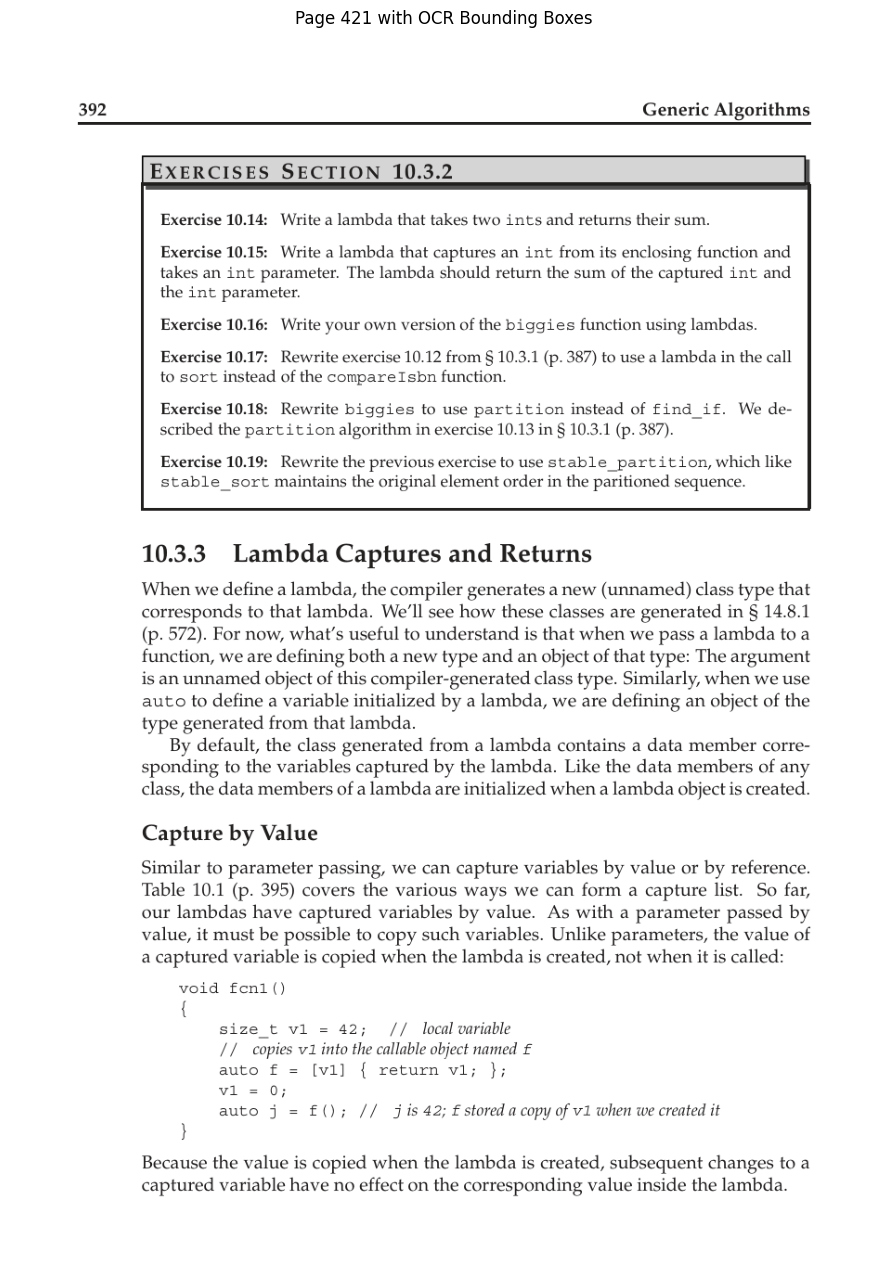

In [ ]:
import fitz  # PyMuPDF
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Load the PDF and the desired page
pdf_path = "/workspace/PYQAnalyser/Primer.pdf"  # Update with your PDF file path
page_number = 420  # Specify the page number to visualize (0-indexed)

# Open the PDF and render the page
doc = fitz.open(pdf_path)
page = doc.load_page(page_number)
pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # Scale for higher resolution

# Convert the page to an image
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

# Example OCR output (replace with actual output from PaddleOCR)
ocr_result = [   # Paste the OCR result for one page here
]

# Draw bounding boxes on the image
draw = ImageDraw.Draw(img)
for line in ocr_result:
    for entry in line:
        box = entry[0]  # Bounding box coordinates
        draw.rectangle([box[0], box[2]], outline="red", width=2)

# Display the image with bounding boxes
plt.figure(figsize=(12, 16))
plt.imshow(img)
plt.axis("off")
plt.title(f"Page {page_number + 1} with OCR Bounding Boxes")
plt.show()


[2024/11/27 19:06:26] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

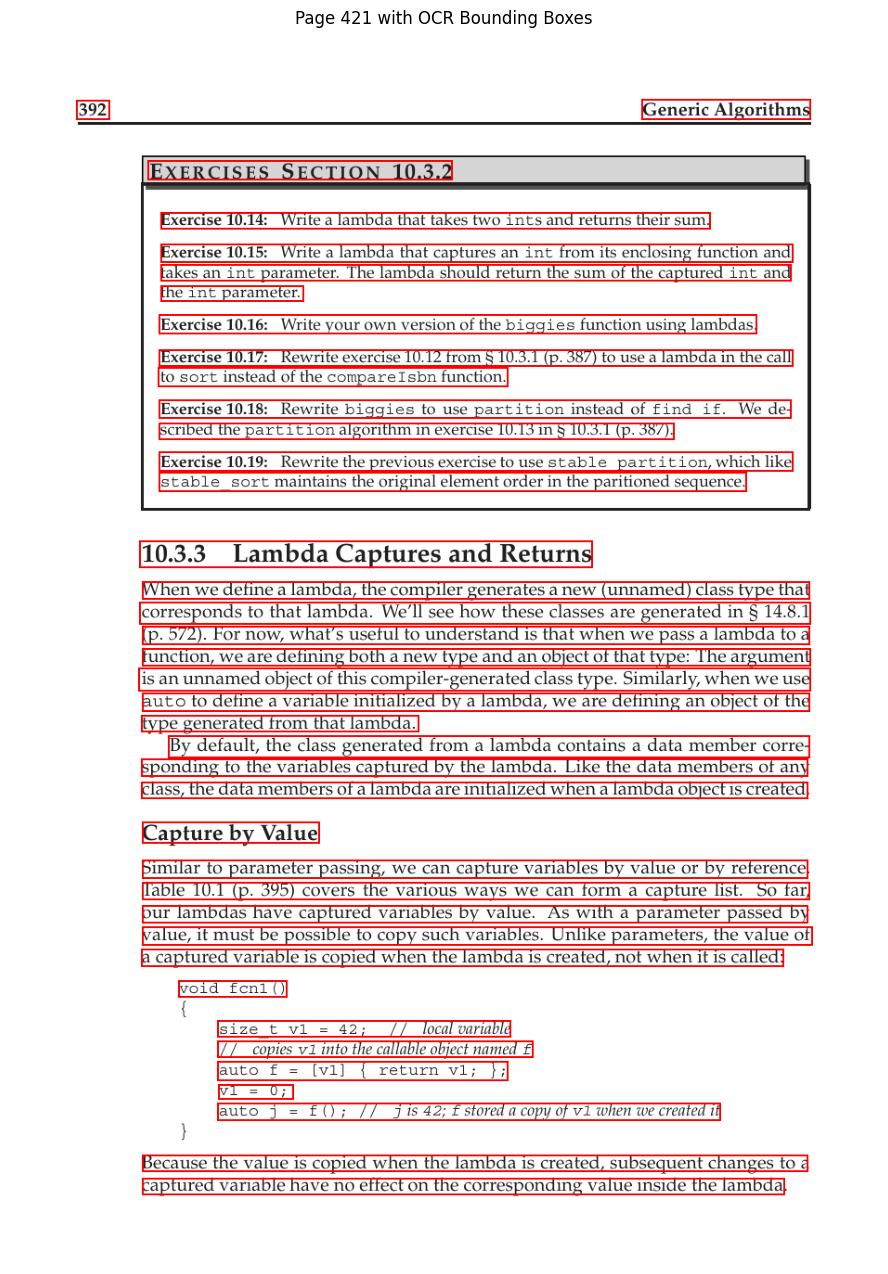

In [ ]:
import fitz  # PyMuPDF
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Initialize PaddleOCR
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Define file paths
pdf_path = r"/workspace/PYQAnalyser/Primer.pdf"
page_number = 420  # Change this to visualize different pages

# Open the PDF and render the page
doc = fitz.open(pdf_path)
page = doc.load_page(page_number)
mat = fitz.Matrix(2, 2)  # Increase resolution
pix = page.get_pixmap(matrix=mat)
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

# Perform OCR on the image
img_np = np.array(img)
result = ocr.ocr(img_np, cls=True)

# Draw bounding boxes on the image
draw = ImageDraw.Draw(img)
for line in result:
    for entry in line:
        box = entry[0]  # Bounding box coordinates
        top_left = (box[0][0], box[0][1])  # First point (x0, y0)
        bottom_right = (box[2][0], box[2][1])  # Third point (x2, y2)
        draw.rectangle([top_left, bottom_right], outline="red", width=2)

# Display the image with bounding boxes
plt.figure(figsize=(12, 16))
plt.imshow(img)
plt.axis("off")
plt.title(f"Page {page_number + 1} with OCR Bounding Boxes")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


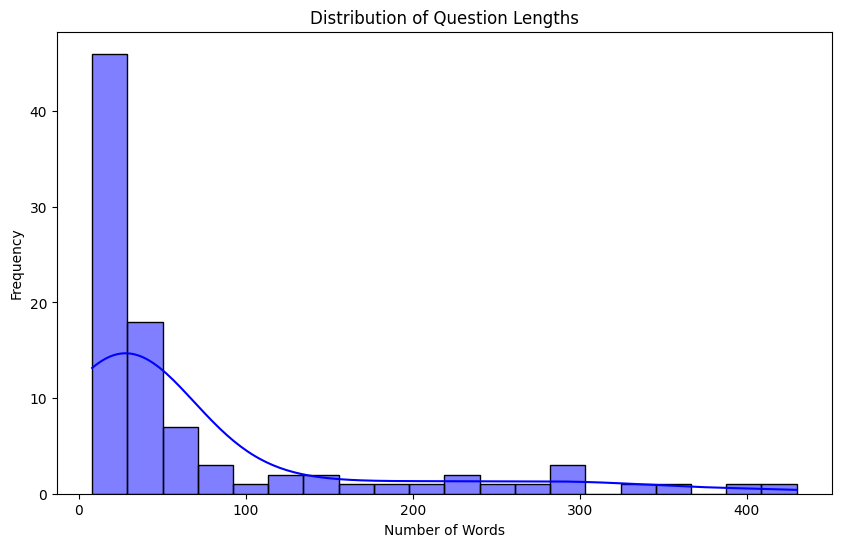

/tmp/ipykernel_45/3310604887.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20), palette='viridis')


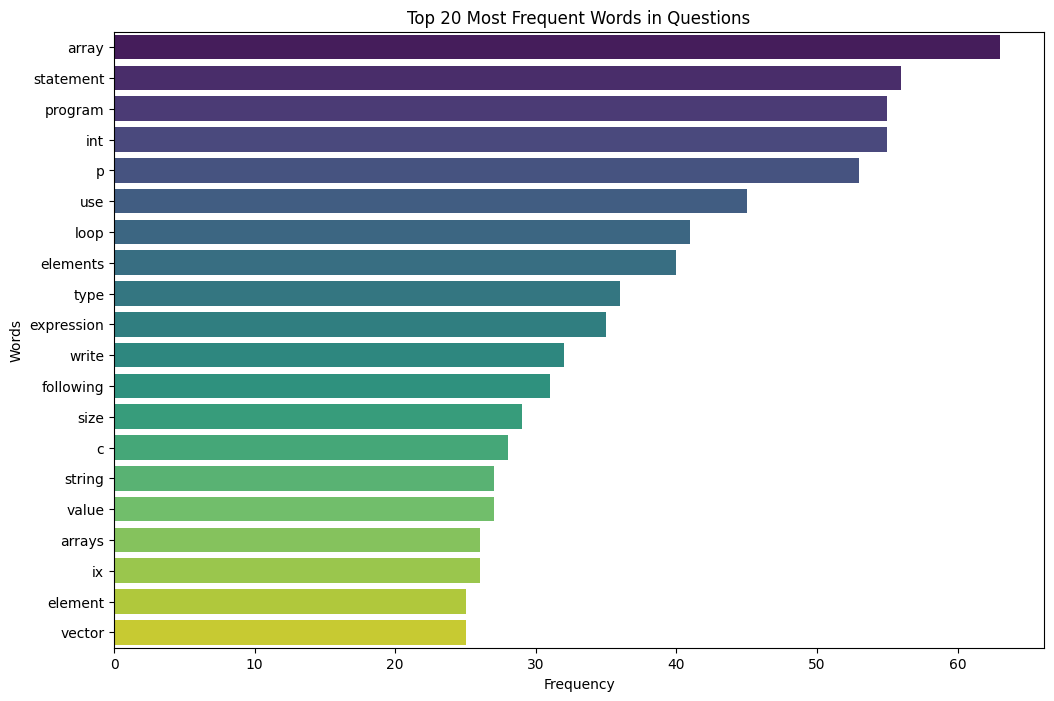

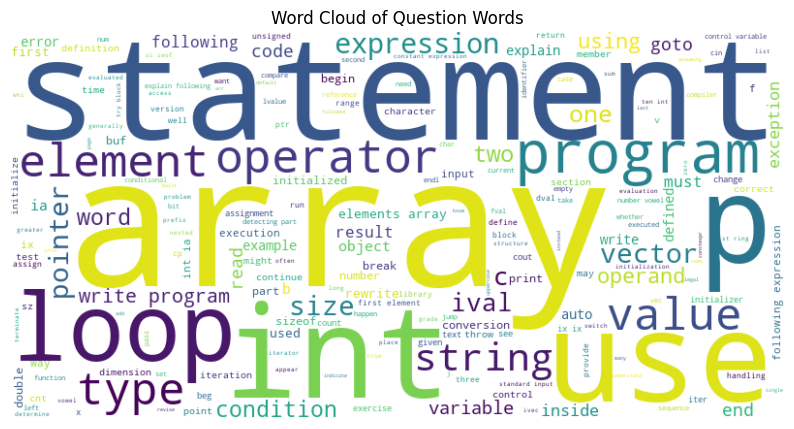

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import nltk

nltk.download('stopwords')
nltk.download('punkt')

# Load CSV
df = pd.read_csv(r"/workspace/PYQAnalyser/extracted_exercises-2.csv")

# Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenize text
    words = [word for word in words if word not in stopwords.words('english') and word.isalpha()]  # Remove stopwords and non-alphabetic tokens
    return words

# Apply preprocessing to the 'Question Text' column
df['Processed Words'] = df['Question Text'].apply(lambda x: preprocess_text(str(x)))

# Flatten the list of words for frequency analysis
all_words = [word for sublist in df['Processed Words'] for word in sublist]
word_freq = Counter(all_words)

# Convert to DataFrame for visualization
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot 1: Question Length Distribution
df['Question Length'] = df['Question Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['Question Length'], bins=20, kde=True, color='blue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Top 20 Words Frequency
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20), palette='viridis')
plt.title('Top 20 Most Frequent Words in Questions')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# Plot 3: Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Question Words')
plt.show()
